In [2]:
import os
from utils import DataSeq, load_ids, load_pickle_mv

import numpy as np
import pandas as pd
import skimage.io as io

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import F1Score
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.losses import Loss

import keras_tuner as kt

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [3]:
pkl_path = "./mv.pkl"
images_path = "./Train_non_experts_simple/"
test_path = "./Test/"
batch_size = 8
epochs = 10

In [5]:
ids, labels = load_pickle_mv(pkl_path, images_path)
print(ids.shape, labels.shape)
X_train, X_valid, y_train, y_valid = train_test_split(ids, labels, test_size=0.2, random_state=42)

test_ids, test_labels = load_ids(test_path)
print(test_ids.shape, test_labels.shape)
test_seq = DataSeq(test_ids, test_labels)

(75243,) (75243, 3)
(4364,) (4364, 3)


In [6]:
# Loading images with generator

train_seq = DataSeq(X_train, y_train)
valid_seq = DataSeq(X_valid, y_valid)

train_steps = len(X_train) // batch_size
valid_steps = len(X_valid) // batch_size

# Focal loss

In [7]:
class FocalLoss(Loss):
    def __init__(self, gamma=2.0, alpha=None, num_classes=None):
        super().__init__()
        self.gamma = gamma
        if num_classes is None:
            raise ValueError("The 'num_classes' parameter must be specified.")
        if alpha is None:
            alpha = [1 for _ in range(num_classes)]
        elif len(alpha) != num_classes:
            raise ValueError("The length of 'alpha' must be equal to 'num_classes'.")
        self.alpha = tf.convert_to_tensor(alpha, dtype=tf.float32)

    def call(self, y_true, y_pred):
        y_pred_clip = tf.clip_by_value(y_pred, clip_value_min=1e-4, clip_value_max=1-1e-4)
        cce = tf.keras.losses.CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
        entropy = cce(y_true, y_pred)

        weight = tf.math.pow(1.0 - y_pred_clip, self.gamma) 
        focal = tf.reduce_sum(y_true * self.alpha * weight, axis=1)
        loss = focal * entropy
        
        return tf.reduce_mean(loss)


# Hyperparameter Tuning

In [8]:
def build_model(hp = None):
    input_layer = Input(shape=(224, 224, 3))

    data_augmentation = tf.keras.Sequential([
        input_layer,
        tf.keras.layers.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.RandomRotation(0.15),
    ])
    
    vgg = tf.keras.applications.VGG16(weights=None, include_top=False, input_tensor=data_augmentation.output)
    vgg.load_weights('./vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')
    vgg.trainable = False

    model = vgg.output
    model = Flatten()(model)
    model = Dense(4096, activation='relu')(model)
    model = Dropout(0.25)(model)

    model = Dense(3, activation='softmax')(model)
    
    gamma = 2
    alpha = None

    if not hp is None:
        gamma = hp.Float("gamma", min_value=1.0, max_value=5.0, step=0.5)
        alpha1 = hp.Float("alpha1", min_value=0.01, max_value=1, step=0.01)
        alpha2 = hp.Float("alpha2", min_value=0.01, max_value=1, step=0.01)
        alpha3 = hp.Float("alpha3", min_value=0.01, max_value=1, step=0.01)
        alpha = [alpha1, alpha2, alpha3]

    model = Model(input_layer, model, name="Transfer_VGG16")
    
    model.compile(optimizer="adam", loss=FocalLoss(gamma=gamma, alpha=alpha, num_classes=3), metrics=["accuracy"])
    return model

In [9]:
obj = kt.Objective("val_loss", "min")

tuner = kt.BayesianOptimization(
    hypermodel=build_model,
    objective=obj,
    max_trials=10,
    executions_per_trial=1,
    overwrite=False,
    directory='./tuner_results/',
    project_name='MV_Focal_Loss',
)

tuner.search_space_summary()

INFO:tensorflow:Reloading Tuner from ./tuner_results/MV_Focal_Loss/tuner0.json
Search space summary
Default search space size: 4
gamma (Float)
{'default': 1.0, 'conditions': [], 'min_value': 1.0, 'max_value': 5.0, 'step': 0.5, 'sampling': 'linear'}
alpha1 (Float)
{'default': 0.01, 'conditions': [], 'min_value': 0.01, 'max_value': 1.0, 'step': 0.01, 'sampling': 'linear'}
alpha2 (Float)
{'default': 0.01, 'conditions': [], 'min_value': 0.01, 'max_value': 1.0, 'step': 0.01, 'sampling': 'linear'}
alpha3 (Float)
{'default': 0.01, 'conditions': [], 'min_value': 0.01, 'max_value': 1.0, 'step': 0.01, 'sampling': 'linear'}


In [10]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)

# This call is for images using a generator/sequence
tuner.search(train_seq, validation_data=valid_seq, steps_per_epoch=train_steps,
    validation_steps=valid_steps, epochs=epochs, callbacks=[stop_early])


INFO:tensorflow:Oracle triggered exit


In [11]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
alpha = [best_hps.get('alpha1'), best_hps.get('alpha2'), best_hps.get('alpha3')]

print(f"Optimal value for gamma: {best_hps.get('gamma')}")
print(f"Optimal values of alpha: {alpha}")

Optimal value for gamma: 4.5
Optimal values of alpha: [0.04, 0.42000000000000004, 0.92]


In [12]:
model = tuner.hypermodel.build(best_hps)
model.summary()

Model: "Transfer_VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 random_flip (RandomFlip)    (None, 224, 224, 3)       0         
                                                                 
 random_rotation (RandomRot  (None, 224, 224, 3)       0         
 ation)                                                          
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                    

In [13]:
tuner.results_summary()

Results summary
Results in ./tuner_results/MV_Focal_Loss
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 01 summary
Hyperparameters:
gamma: 4.5
alpha1: 0.04
alpha2: 0.42000000000000004
alpha3: 0.92
Score: 0.01532684825360775

Trial 02 summary
Hyperparameters:
gamma: 1.0
alpha1: 0.54
alpha2: 0.03
alpha3: 0.060000000000000005
Score: 0.022714665159583092

Trial 07 summary
Hyperparameters:
gamma: 2.5
alpha1: 0.74
alpha2: 0.05
alpha3: 0.22
Score: 0.02298690192401409

Trial 06 summary
Hyperparameters:
gamma: 2.5
alpha1: 0.46
alpha2: 0.52
alpha3: 0.05
Score: 0.036823857575654984

Trial 08 summary
Hyperparameters:
gamma: 3.5
alpha1: 0.93
alpha2: 0.33
alpha3: 0.24000000000000002
Score: 0.03704545646905899

Trial 05 summary
Hyperparameters:
gamma: 4.0
alpha1: 0.44
alpha2: 0.47000000000000003
alpha3: 0.8400000000000001
Score: 0.041692160069942474

Trial 00 summary
Hyperparameters:
gamma: 4.0
alpha1: 0.65
alpha2: 0.86
alpha3: 0.74
Score: 0.050143077969551086

Trial 04 sum

In [14]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)

X_train, y_train = shuffle(ids, labels, random_state=42)

ids_seq = DataSeq(X_train, y_train)

train_steps = len(X_train) // batch_size
test_steps = len(test_ids) // batch_size

history = model.fit(ids_seq, validation_data=test_seq, steps_per_epoch=train_steps,
 validation_steps=test_steps, epochs=10, callbacks=[stop_early])

Epoch 1/10


2023-10-19 09:12:55.223198: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-10-19 09:12:56.563256: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-19 09:12:57.274425: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-10-19 09:12:57.296264: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f3cbc3ace80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-19 09:12:57.296345: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2023-10-19 09:12:57.326756: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-19 09:12:57.51825

9405/9405 [==============================] - 488s 51ms/step - loss: 0.0576 - accuracy: 0.4946 - val_loss: 0.0485 - val_accuracy: 0.2658
Epoch 2/10
9405/9405 [==============================] - 488s 52ms/step - loss: 0.0196 - accuracy: 0.4440 - val_loss: 0.0174 - val_accuracy: 0.3461
Epoch 3/10
9405/9405 [==============================] - 483s 51ms/step - loss: 0.0187 - accuracy: 0.4462 - val_loss: 0.0203 - val_accuracy: 0.3165
Epoch 4/10
9405/9405 [==============================] - 483s 51ms/step - loss: 0.0188 - accuracy: 0.4453 - val_loss: 0.0181 - val_accuracy: 0.3339
Epoch 5/10
9405/9405 [==============================] - 480s 51ms/step - loss: 0.0183 - accuracy: 0.4499 - val_loss: 0.0183 - val_accuracy: 0.2975
Epoch 6/10
9405/9405 [==============================] - 482s 51ms/step - loss: 0.0188 - accuracy: 0.4478 - val_loss: 0.0205 - val_accuracy: 0.3048


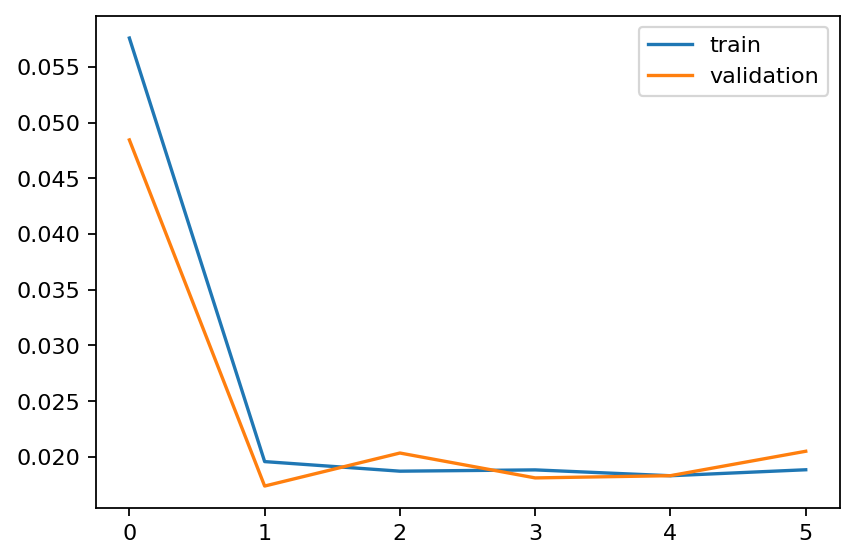

In [15]:
plt.figure(figsize=(6, 4), dpi=160)
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="validation")
plt.legend()
plt.show()

In [16]:
y_pred = model.predict(test_seq)
y_pred = np.argmax(y_pred,axis=1)
print(classification_report(np.argmax(test_labels, axis=1), y_pred))

546/546 [==============================] - 18s 33ms/step
              precision    recall  f1-score   support

           0       0.67      0.00      0.00      2692
           1       0.28      1.00      0.44      1196
           2       1.00      0.28      0.43       476

    accuracy                           0.30      4364
   macro avg       0.65      0.43      0.29      4364
weighted avg       0.60      0.30      0.17      4364



In [17]:
 model.save_weights('./bcss_aug_weights_mv_focal_loss.h5')